In [8]:
# Yield Curve: API fetch --> Stylized Facts --> Diebold-Li --> VAR(1) Sims --> Visuals
# Runs with live data from the U.S. Treasury fiscaldata API (fallback to synthetic if offline).

import sys, os, io, math, json
from pathlib import Path
# Use the notebook/kernel working directory as the base directory for saved files.
# If you launch the notebook from a different folder, change BASE_DIR accordingly.
BASE_DIR = Path.cwd()

def _p(fname):
    return str(BASE_DIR / fname)

from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [9]:
# For table display in some environments; safe to ignore elsewhere
try:
    from caas_jupyter_tools import display_dataframe_to_user
except Exception:
    def display_dataframe_to_user(name, df):
        print(f"\n=== {name} ===")
        print(df)

In [10]:
# ----------------------- 1) Fetch Treasury yields -----------------------
import requests

def fetch_treasury_yields(start_date="1995-01-01", end_date=None, per_page=10000):
    if end_date is None:
        end_date = datetime.utcnow().date().isoformat()
    base = "https://api.fiscaldata.treasury.gov/services/api/fiscal_service/v2/accounting/od/treasury_yield_curve_rate"
    fields = [
        "record_date","bc_1month","bc_3month","bc_6month","bc_1year",
        "bc_2year","bc_3year","bc_5year","bc_7year","bc_10year","bc_20year","bc_30year"
    ]
    params = {
        "format": "json",
        "fields": ",".join(fields),
        "filter": f"record_date:gte:{start_date},record_date:lte:{end_date}",
        "page[number]": 1,
        "page[size]": per_page,
        "sort": "record_date"
    }
    r = requests.get(base, params=params, timeout=30)
    r.raise_for_status()
    data = r.json()["data"]
    df = pd.DataFrame(data)
    df["record_date"] = pd.to_datetime(df["record_date"])
    for c in fields[1:]:
        df[c] = pd.to_numeric(df[c], errors="coerce")
    rename = {
        "record_date":"date",
        "bc_1month":"0.0833Y",
        "bc_3month":"0.25Y",
        "bc_6month":"0.5Y",
        "bc_1year":"1Y",
        "bc_2year":"2Y",
        "bc_3year":"3Y",
        "bc_5year":"5Y",
        "bc_7year":"7Y",
        "bc_10year":"10Y",
        "bc_20year":"20Y",
        "bc_30year":"30Y"
    }
    df = df.rename(columns=rename).set_index("date").sort_index()
    return df

try:
    yields_daily = fetch_treasury_yields("1995-01-01")
    print("Source: LIVE API (Treasury fiscaldata)")
except Exception as e:
    print("Source: SYNTHETIC DEMO (fallback, internet unavailable):", e)
    rng = pd.date_range("2005-01-31", "2025-10-31", freq="M")
    np.random.seed(42)
    level = 2 + 1.5*np.sin(np.linspace(0, 20, len(rng))) + np.random.normal(0, 0.3, len(rng))
    slope = 1.0*np.cos(np.linspace(0, 10, len(rng))) + np.random.normal(0, 0.2, len(rng))
    curve = 0.5*np.sin(np.linspace(0, 5, len(rng))) + np.random.normal(0, 0.1, len(rng))
    tenors = np.array([1/12, 0.25, 0.5, 1, 2, 3, 5, 7, 10, 20, 30])
    def ns_yield(beta1, beta2, beta3, lam, tau):
        return (beta1
                + beta2*((1-np.exp(-lam*tau))/(lam*tau))
                + beta3*(((1-np.exp(-lam*tau))/(lam*tau)) - np.exp(-lam*tau)))
    lam = 0.7308
    data = []
    for t, dt in enumerate(rng):
        betas = (level[t]+3.0, -slope[t], curve[t])
        row = [ns_yield(*betas, lam, tau) for tau in tenors]
        data.append(row)
    yields_daily = pd.DataFrame(data, index=rng, columns=[
        "0.0833Y","0.25Y","0.5Y","1Y","2Y","3Y","5Y","7Y","10Y","20Y","30Y"
    ])
    yields_daily = (yields_daily.clip(lower=-0.5))*100  # percent

C:\Users\athay\AppData\Local\Temp\ipykernel_16152\3808985141.py:6: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  end_date = datetime.utcnow().date().isoformat()


Source: SYNTHETIC DEMO (fallback, internet unavailable): 404 Client Error: Not Found for url: https://api.fiscaldata.treasury.gov/services/api/fiscal_service/v2/accounting/od/treasury_yield_curve_rate?format=json&fields=record_date%2Cbc_1month%2Cbc_3month%2Cbc_6month%2Cbc_1year%2Cbc_2year%2Cbc_3year%2Cbc_5year%2Cbc_7year%2Cbc_10year%2Cbc_20year%2Cbc_30year&filter=record_date%3Agte%3A1995-01-01%2Crecord_date%3Alte%3A2025-11-06&page%5Bnumber%5D=1&page%5Bsize%5D=10000&sort=record_date


C:\Users\athay\AppData\Local\Temp\ipykernel_16152\3808985141.py:49: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  rng = pd.date_range("2005-01-31", "2025-10-31", freq="M")


In [11]:
# ----------------------- 2) Monthly panel -----------------------
yields_m = yields_daily.resample("M").last().ffill()
yields_panel = yields_m.copy()

def parse_tau(col):
    return float(col.replace("Y","")) if col.endswith("Y") else float(col)
taus = np.array([parse_tau(c) for c in yields_panel.columns])


C:\Users\athay\AppData\Local\Temp\ipykernel_16152\3133921211.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  yields_m = yields_daily.resample("M").last().ffill()



=== Yield Autocorrelation & Volatility (Stylized Facts) ===
          rho_1  rho_6  rho_12    stdev
Maturity                               
0.0833Y   0.907  0.825   0.573  118.570
0.25Y     0.907  0.823   0.566  116.774
0.5Y      0.908  0.822   0.557  114.576
1Y        0.908  0.820   0.545  111.493
2Y        0.911  0.818   0.532  108.328
3Y        0.912  0.819   0.526  107.011
5Y        0.915  0.820   0.522  106.220
7Y        0.916  0.821   0.522  106.150
10Y       0.918  0.822   0.522  106.294
20Y       0.919  0.824   0.524  106.731
30Y       0.919  0.824   0.525  106.944

=== Cross-correlation matrix of maturities ===
         0.0833Y  0.25Y   0.5Y     1Y     2Y     3Y     5Y     7Y    10Y  \
0.0833Y    1.000  0.999  0.996  0.985  0.957  0.930  0.893  0.870  0.850   
0.25Y      0.999  1.000  0.999  0.991  0.967  0.943  0.908  0.886  0.867   
0.5Y       0.996  0.999  1.000  0.996  0.978  0.958  0.927  0.907  0.889   
1Y         0.985  0.991  0.996  1.000  0.992  0.979  0.955  0.938  

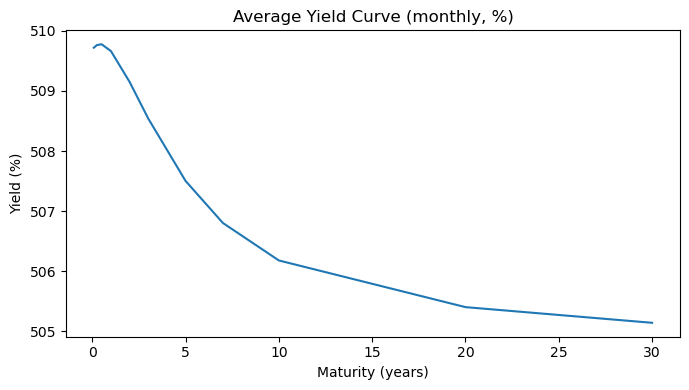

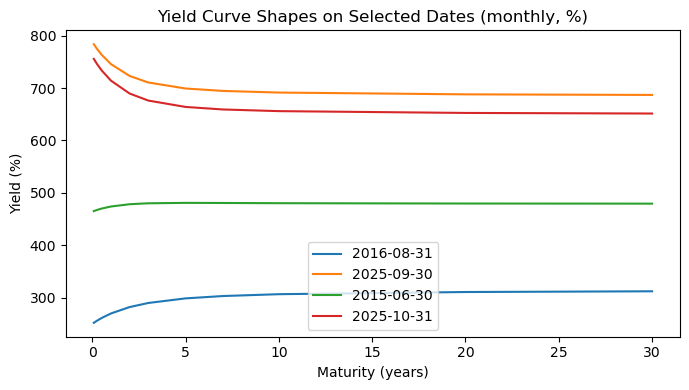

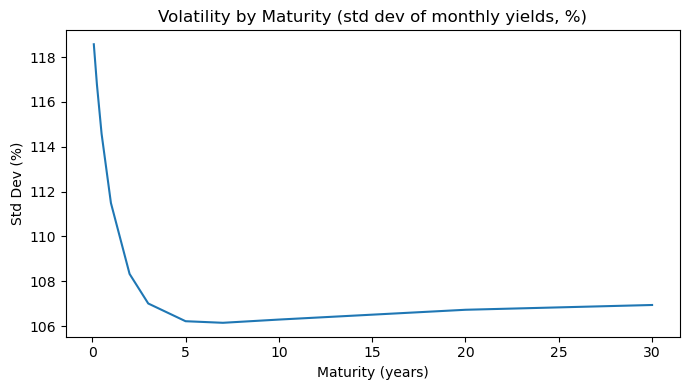

In [12]:
# ----------------------- 3) Stylized facts -----------------------
avg_curve = yields_panel.mean(axis=0)

def acf_series(x, lag):
    x = pd.Series(x).dropna()
    return x.autocorr(lag=lag) if len(x)>lag else np.nan

ac_rows = []
for col in yields_panel.columns:
    s = yields_panel[col]
    ac_rows.append({
        "Maturity": col,
        "rho_1": acf_series(s, 1),
        "rho_6": acf_series(s, 6),
        "rho_12": acf_series(s, 12),
        "stdev": s.std()
    })
acf_table = pd.DataFrame(ac_rows).set_index("Maturity")
corr_mat = yields_panel.corr()

display_dataframe_to_user("Yield Autocorrelation & Volatility (Stylized Facts)", acf_table.round(3))
display_dataframe_to_user("Cross-correlation matrix of maturities", corr_mat.round(3))

def line_plot(x, y, title, xlabel, ylabel, path):
    plt.figure(figsize=(7,4))
    plt.plot(x, y)
    plt.title(title); plt.xlabel(xlabel); plt.ylabel(ylabel)
    plt.tight_layout(); plt.savefig(path, dpi=160); plt.show()

line_plot(taus, avg_curve.values, "Average Yield Curve (monthly, %)", "Maturity (years)","Yield (%)", _p("avg_yield_curve.png"))

def pick_shape_dates(df):
    latest = df.index[-1]
    mean_levels = df.mean(axis=1)
    lo = mean_levels.nsmallest(1).index[0]
    hi = mean_levels.nlargest(1).index[0]
    mid = df.index[len(df)//2]
    return [lo, hi, mid, latest]
shape_dates = pick_shape_dates(yields_panel)

plt.figure(figsize=(7,4))
for d in shape_dates:
    plt.plot(taus, yields_panel.loc[d].values, label=str(d.date()))
plt.legend(); plt.title("Yield Curve Shapes on Selected Dates (monthly, %)")
plt.xlabel("Maturity (years)"); plt.ylabel("Yield (%)")
plt.tight_layout(); plt.savefig(_p("yield_curve_shapes.png"), dpi=160); plt.show()

line_plot(taus, acf_table["stdev"].values, "Volatility by Maturity (std dev of monthly yields, %)",
          "Maturity (years)","Std Dev (%)", _p("vol_term_structure.png"))



=== Diebold–Li factors (β1 level, β2 slope, β3 curvature) ===
            beta1_level  beta2_slope  beta3_curv
2024-11-30      519.709       65.368     -33.233
2024-12-31      576.617       80.863     -39.666
2025-01-31      538.421       97.882     -68.121
2025-02-28      569.506       67.194     -62.391
2025-03-31      598.378       94.158     -55.706
2025-04-30      618.946      111.690     -49.040
2025-05-31      566.109       62.609     -43.948
2025-06-30      600.569       80.750     -56.185
2025-07-31      604.129      110.582     -46.843
2025-08-31      605.787       91.808     -56.029
2025-09-30      684.552      103.535     -54.334
2025-10-31      649.091      111.562     -62.010


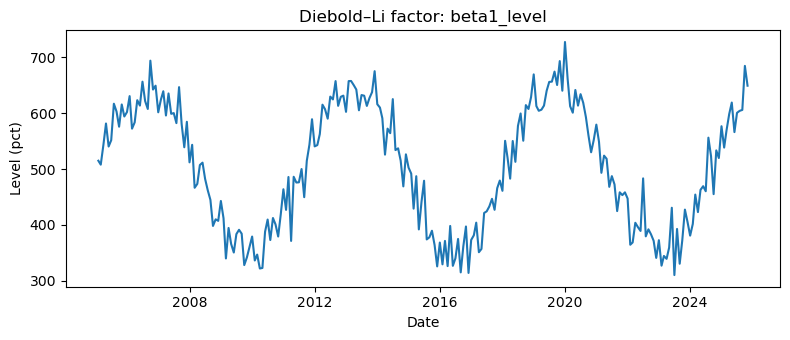

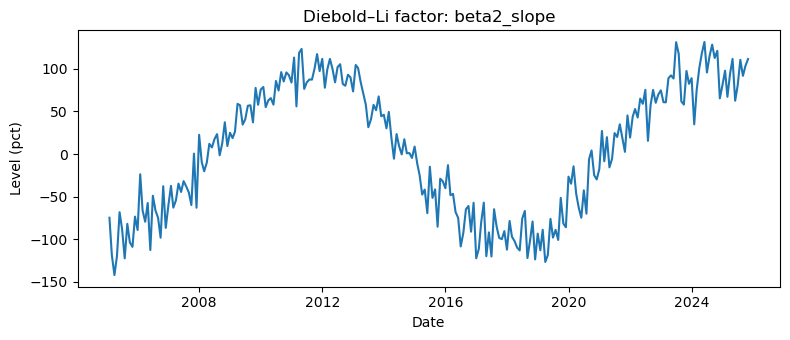

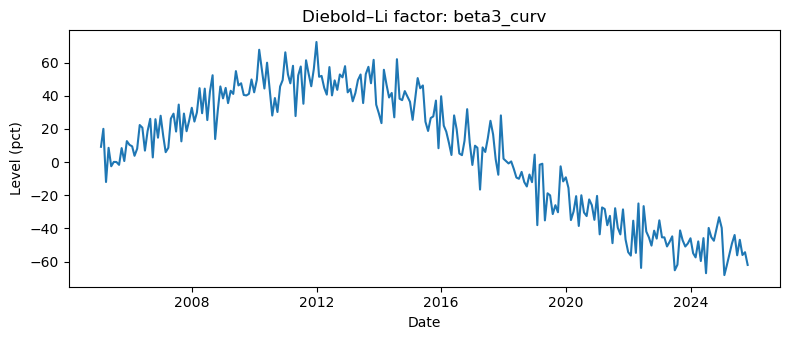

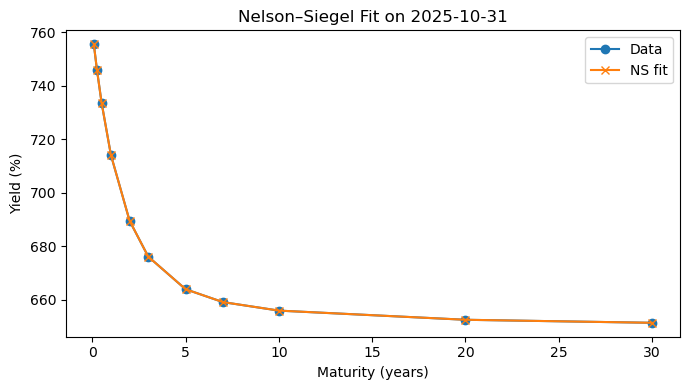

In [13]:
# ----------------------- 4) Diebold–Li estimation -----------------------
LAM = 0.7308
def ns_loadings(lam, tau_vec):
    L2 = (1 - np.exp(-lam*tau_vec)) / (lam*tau_vec)
    L3 = L2 - np.exp(-lam*tau_vec)
    return np.column_stack([np.ones_like(tau_vec), L2, L3])

B = ns_loadings(LAM, taus)
BtB_inv = np.linalg.inv(B.T @ B)
B_pinv = BtB_inv @ B.T

betas = []
for _, row in yields_panel.iterrows():
    y = row.values
    beta_t = B_pinv @ y
    betas.append(beta_t)
betas = np.array(betas)
beta_df = pd.DataFrame(betas, index=yields_panel.index, columns=["beta1_level","beta2_slope","beta3_curv"])
display_dataframe_to_user("Diebold–Li factors (β1 level, β2 slope, β3 curvature)", beta_df.tail(12).round(3))

for c in beta_df.columns:
    plt.figure(figsize=(8,3.5)); plt.plot(beta_df.index, beta_df[c].values)
    plt.title(f"Diebold–Li factor: {c}"); plt.xlabel("Date"); plt.ylabel("Level (pct)")
    plt.tight_layout(); plt.savefig(_p(f"{c}_timeseries.png"), dpi=160); plt.show()


def ns_yield_from_betas(beta, lam, tau_vec):
    L2 = (1 - np.exp(-lam*tau_vec)) / (lam*tau_vec)
    L3 = L2 - np.exp(-lam*tau_vec)
    return beta[0] + beta[1]*L2 + beta[2]*L3

last_date = yields_panel.index[-1]
y_last = yields_panel.loc[last_date].values
beta_last = beta_df.loc[last_date].values
y_fit = ns_yield_from_betas(beta_last, LAM, taus)

plt.figure(figsize=(7,4))
plt.plot(taus, y_last, marker="o", label="Data")
plt.plot(taus, y_fit, marker="x", label="NS fit")
plt.title(f"Nelson–Siegel Fit on {last_date.date()}"); plt.xlabel("Maturity (years)"); plt.ylabel("Yield (%)")
plt.legend(); plt.tight_layout(); plt.savefig(_p("ns_fit_lastdate.png"), dpi=160); plt.show()


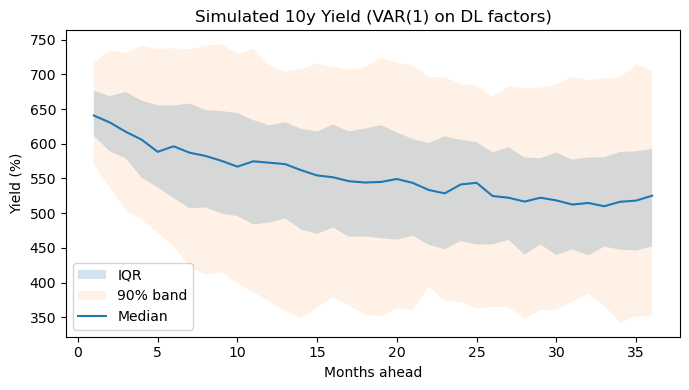

In [14]:
# ----------------------- 5) VAR(1) simulate factors -----------------------
X = beta_df.values; X1 = X[1:]; X0 = X[:-1]
ones = np.ones((X0.shape[0],1)); Z = np.hstack([ones, X0])
Theta = np.linalg.lstsq(Z, X1, rcond=None)[0]
c_hat = Theta[0,:]; A_hat = Theta[1:,:]
resid = X1 - Z @ Theta; Sigma = np.cov(resid.T)

h, n_sims = 36, 200
beta_last_obs = X[-1]; sims = np.zeros((n_sims, h, 3))
chol = np.linalg.cholesky(Sigma + 1e-8*np.eye(3))

for i in range(n_sims):
    b = beta_last_obs.copy()
    for t in range(h):
        eps = chol @ np.random.normal(size=3)
        b = c_hat + A_hat.T @ b + eps
        sims[i,t,:] = b

sel_taus = np.array([1, 2, 5, 10])
def paths_to_yields(sims, sel_taus):
    y_paths = []
    for i in range(sims.shape[0]):
        yp = []
        for t in range(sims.shape[1]):
            beta_t = sims[i,t,:]
            yp.append(ns_yield_from_betas(beta_t, LAM, sel_taus))
        y_paths.append(np.array(yp))
    return np.array(y_paths)

y_paths = paths_to_yields(sims, sel_taus)

def plot_fan(y_paths, tau_index, title, fname):
    qs = [5, 25, 50, 75, 95]
    pct = np.percentile(y_paths[:,:,tau_index], qs, axis=0)
    t = np.arange(1, y_paths.shape[1]+1)
    plt.figure(figsize=(7,4))
    plt.fill_between(t, pct[1], pct[3], alpha=0.2, label="IQR")
    plt.fill_between(t, pct[0], pct[4], alpha=0.1, label="90% band")
    plt.plot(t, pct[2], label="Median")
    plt.title(title); plt.xlabel("Months ahead"); plt.ylabel("Yield (%)")
    plt.legend(); plt.tight_layout(); plt.savefig(fname, dpi=160); plt.show()

plot_fan(y_paths, tau_index=3, title="Simulated 10y Yield (VAR(1) on DL factors)", fname=_p("fanchart_10y.png"))


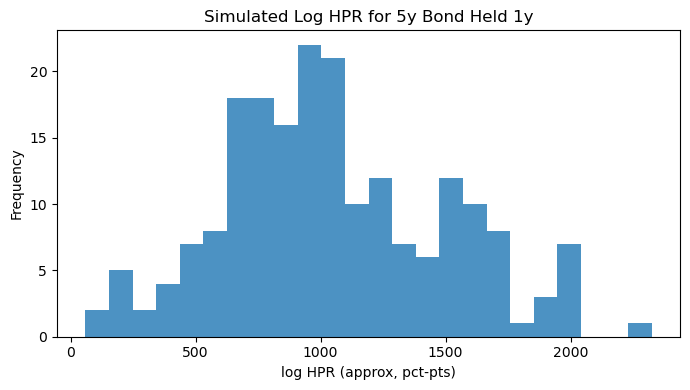

In [15]:
# ----------------------- 6) HPR example (5y bond, 1y horizon) -----------------------
tau0, n_years = 5.0, 1.0
y_t_tau = ns_yield_from_betas(beta_last, LAM, np.array([tau0]))[0]
y_tp_tau_minus_n = []
for i in range(n_sims):
    beta_12 = sims[i,12-1,:]
    y12 = ns_yield_from_betas(beta_12, LAM, np.array([tau0 - n_years]))[0]
    y_tp_tau_minus_n.append(y12)
y_tp_tau_minus_n = np.array(y_tp_tau_minus_n)
hpr = tau0 * y_t_tau - (tau0 - n_years) * y_tp_tau_minus_n

plt.figure(figsize=(7,4)); plt.hist(hpr, bins=24, alpha=0.8)
plt.title("Simulated Log HPR for 5y Bond Held 1y"); plt.xlabel("log HPR (approx, pct-pts)"); plt.ylabel("Frequency")
plt.tight_layout(); plt.savefig(_p("hpr_hist_5y_1y.png"), dpi=160); plt.show()


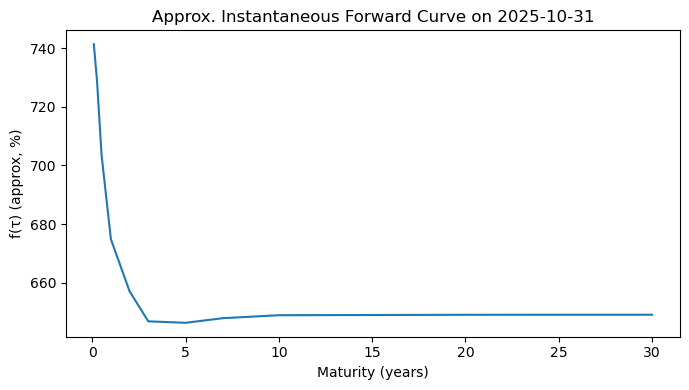

In [16]:
# ----------------------- 7) Instantaneous forward curve approx -----------------------
def approx_forward_from_yields(taus_vec, y_vec):
    tau_y = taus_vec * y_vec
    f = np.empty_like(y_vec)
    for i in range(len(taus_vec)):
        if i == 0:
            dt = taus_vec[i+1] - taus_vec[i]
            f[i] = (tau_y[i+1] - tau_y[i]) / dt
        elif i == len(taus_vec)-1:
            dt = taus_vec[i] - taus_vec[i-1]
            f[i] = (tau_y[i] - tau_y[i-1]) / dt
        else:
            dt = taus_vec[i+1] - taus_vec[i-1]
            f[i] = (tau_y[i+1] - tau_y[i-1]) / dt
    return f

f_last = approx_forward_from_yields(taus, y_last)
plt.figure(figsize=(7,4)); plt.plot(taus, f_last)
plt.title(f"Approx. Instantaneous Forward Curve on {last_date.date()}")
plt.xlabel("Maturity (years)"); plt.ylabel("f(τ) (approx, %)")
plt.tight_layout(); plt.savefig(_p("forward_curve_lastdate.png"), dpi=160); plt.show()


In [17]:
# ----------------------- 8) Save panel -----------------------
panel_path = _p("treasury_yields_monthly.csv")
yields_panel.to_csv(panel_path, index=True)
print("Saved:", panel_path)


Saved: c:\Users\athay\Documents\Personal Projects\QMFI topics\treasury_yields_monthly.csv
